In [154]:
import sympy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [185]:
# mu = 3.986e14
mu = 1.0

# Analytical
def function(p_vec):
    p_norm = np.linalg.norm(p_vec)
    return -mu * p_vec / p_norm**3

def first_order_partial_derivatives(p_vec):
    n = len(p_vec)
    p_norm = np.linalg.norm(p_vec)
    return -mu * (np.eye(n) / p_norm**3 - 3 * np.outer(p_vec, p_vec) / p_norm**5)

def second_order_partial_derivatives(p_vec):
    n = len(p_vec)
    p_norm = np.linalg.norm(p_vec)
    return -mu * (-3 / p_norm**5 * (np.outer(np.eye(n), p_vec) + np.kron(np.eye(n), p_vec) + np.kron(p_vec, np.eye(n))) + 15 / p_norm**7 * np.kron(p_vec, np.outer(p_vec, p_vec))).reshape(n, n, n) 

In [ ]:
# Symbolic
p1, p2, p3 = sp.symbols('p1 p2 p3')
p_vec = sp.Matrix([p1, p2, p3])
p_norm = sp.sqrt(p1**2 + p2**2 + p3**2)
fun = -mu * p_vec / p_norm**3
first_order_der = sp.derive_by_array(fun, (p1, p2, p3))
first_order_der_fun = sp.lambdify((p1, p2, p3), sp.ImmutableDenseNDimArray(first_order_der).tolist(), 'numpy')
second_order_der = sp.derive_by_array(first_order_der, (p1, p2, p3))
second_order_der_fun = sp.lambdify((p1, p2, p3), sp.ImmutableDenseNDimArray(second_order_der).tolist(), 'numpy')

# Example point
std = 1e-1
sample_p_vec = np.random.multivariate_normal(mean=[0, 0, 0], cov=std*np.eye(3))

# First Order Partial Derivatives Comparison
first_order_partial_derivatives_symbolic = np.array(first_order_der_fun(*sample_p_vec)).reshape((3, 3))
first_order_partial_derivatives_analytical = first_order_partial_derivatives(sample_p_vec.reshape((3, 1)))
print(first_order_partial_derivatives_symbolic)
print(first_order_partial_derivatives_analytical)
print(np.allclose(first_order_partial_derivatives_analytical, first_order_partial_derivatives_symbolic, atol=1e-6))

# Second Order Partial Derivatives Comparison
second_order_partial_derivatives_symbolic = np.array(second_order_der_fun(*sample_p_vec)).reshape((3, 3, 3))
second_order_partial_derivatives_analytical = second_order_partial_derivatives(sample_p_vec.reshape((3, 1)))
print(second_order_partial_derivatives_symbolic)
print(second_order_partial_derivatives_analytical)
print(np.allclose(second_order_partial_derivatives_analytical, second_order_partial_derivatives_symbolic, atol=1e-6))

M = 100
all_close_results = []
for _ in range(M):
    sample_p_vec = np.random.multivariate_normal(mean=[0, 0, 0], cov=std*np.eye(3))
    first_order_partial_derivatives_symbolic = np.array(first_order_der_fun(*sample_p_vec)).reshape((3, 3))
    first_order_partial_derivatives_analytical = first_order_partial_derivatives(sample_p_vec.reshape((3, 1)))
    second_order_partial_derivatives_symbolic = np.array(second_order_der_fun(*sample_p_vec)).reshape((3, 3, 3))
    second_order_partial_derivatives_analytical = second_order_partial_derivatives(sample_p_vec.reshape((3, 1)))
    all_close = np.allclose(first_order_partial_derivatives_analytical, first_order_partial_derivatives_symbolic, atol=1e-6) and np.allclose(second_order_partial_derivatives_analytical, second_order_partial_derivatives_symbolic, atol=1e-6)
    all_close_results.append(all_close)
print(f"All Cases Passed?: {all(all_close_results)}")

[[-115.82873631  153.42520973  223.2072761 ]
 [ 153.42520973  -48.55097059  277.44806928]
 [ 223.2072761   277.44806928  164.37970689]]
[[-115.82873631  153.42520973  223.2072761 ]
 [ 153.42520973  -48.55097059  277.44806928]
 [ 223.2072761   277.44806928  164.37970689]]
True
[[[-3954.71715287  -321.9962857   -468.449181  ]
  [ -321.9962857    606.94672386  3571.28551995]
  [ -468.449181    3571.28551995  3347.77042901]]

 [[ -321.9962857    606.94672386  3571.28551995]
  [  606.94672386 -3839.30373178  1097.57840307]
  [ 3571.28551995  1097.57840307  4161.30001748]]

 [[ -468.449181    3571.28551995  3347.77042901]
  [ 3571.28551995  1097.57840307  4161.30001748]
  [ 3347.77042901  4161.30001748  -629.12922208]]]
[[[-3954.71715287  -321.9962857   -468.449181  ]
  [ -321.9962857    606.94672386  3571.28551995]
  [ -468.449181    3571.28551995  3347.77042901]]

 [[ -321.9962857    606.94672386  3571.28551995]
  [  606.94672386 -3839.30373178  1097.57840307]
  [ 3571.28551995  1097.57840

In [ ]:
def differential_equation(x_vec):
    p_vec = x_vec[:3]
    v_vec = x_vec[3:]
    return np.concatenate((v_vec, function(p_vec)))

def first_order_partial_derivatives_for_the_differential_equation(x_vec):
    first_order_der = np.zeros((6, 6))
    p_vec = x_vec[:3]
    first_order_der[:3, 3:] = np.eye(3)
    first_order_der[3:, :3] = first_order_partial_derivatives(p_vec)
    return first_order_der

def second_order_partial_derivatives_for_the_differential_equation(x_vec):
    H_f = np.zeros((6, 6, 6))  # Initialize the full Hessian
    p_vec = x_vec[:3]
    H_f[3:, :3, :3] = second_order_partial_derivatives(p_vec)  # Only nonzero part
    return H_f

def f(dt, x_old):
    k1 = differential_equation(x_old)
    k2 = differential_equation(x_old + dt / 2 * k1)
    k3 = differential_equation(x_old + dt / 2 * k2)
    k4 = differential_equation(x_old + dt * k3)
    return x_old + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

def df_dx(dt, x_old):
    n = len(x_old)
    
    k1 = differential_equation(x_old)
    k2 = differential_equation(x_old + dt / 2 * k1)
    k3 = differential_equation(x_old + dt / 2 * k2)

    dk1 = first_order_partial_derivatives_for_the_differential_equation(x_old)
    dk2 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * dk1)
    dk3 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * dk2)
    dk4 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3) @ (np.eye(n) + dt * dk3)
    return np.eye(n) + dt / 6 * (dk1 + 2 * dk2 + 2 * dk3 + dk4)

def d2f_dx2(dt, x_old):
    n = len(x_old)
    
    k1 = differential_equation(x_old)
    k2 = differential_equation(x_old + dt / 2 * k1)
    k3 = differential_equation(x_old + dt / 2 * k2)

    dk1 = first_order_partial_derivatives_for_the_differential_equation(x_old)
    dk2 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * dk1)
    dk3 = first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * dk2)

    d2k1 = second_order_partial_derivatives_for_the_differential_equation(x_old)
    d2k2 = second_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (np.eye(n) + dt / 2 * dk1) + first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k1) @ (dt / 2 * d2k1)
    d2k3 = second_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (np.eye(n) + dt / 2 * dk2) + first_order_partial_derivatives_for_the_differential_equation(x_old + dt / 2 * k2) @ (dt / 2 * d2k2)
    d2k4 = second_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3) @ (np.eye(n) + dt * dk3) + first_order_partial_derivatives_for_the_differential_equation(x_old + dt * k3) @ (dt * d2k3)
    return dt / 6 * (d2k1 + 2 * d2k2 + 2 * d2k3 + d2k4)

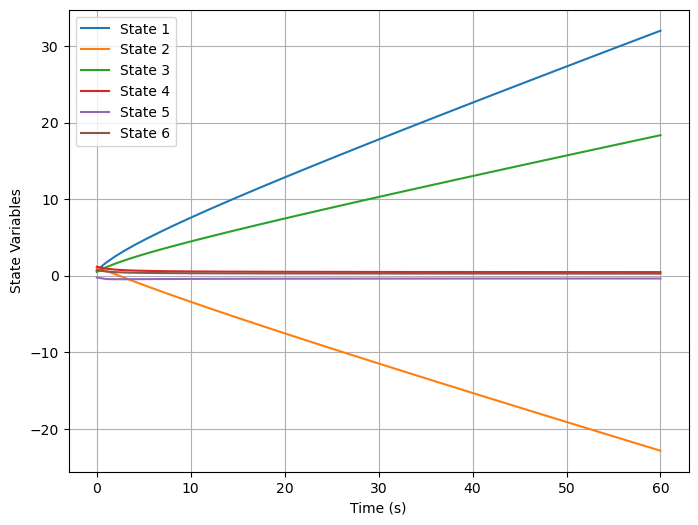

In [144]:
# Define the function
def ode(t, x_vec):
    p_vec = x_vec[:3]
    v_vec = x_vec[3:]
    return np.concatenate((v_vec, function(p_vec)))

# Define initial conditions
t_span = (0, 60)
x0 = np.random.multivariate_normal(mean=[0, 0, 0, 0, 0, 0], cov=np.eye(6))

# Solve the ODE
solution = solve_ivp(ode, t_span, x0, method='RK45', t_eval=np.linspace(0, 60, 61))

# Extract results
t_values = solution.t
x_values = solution.y

plt.figure(figsize=(8, 6))
for i in range(6):
    plt.plot(t_values, x_values[i], label=f'State {i+1}')
plt.xlabel("Time (s)")
plt.ylabel("State Variables")
plt.legend()
plt.grid(True)
plt.show()

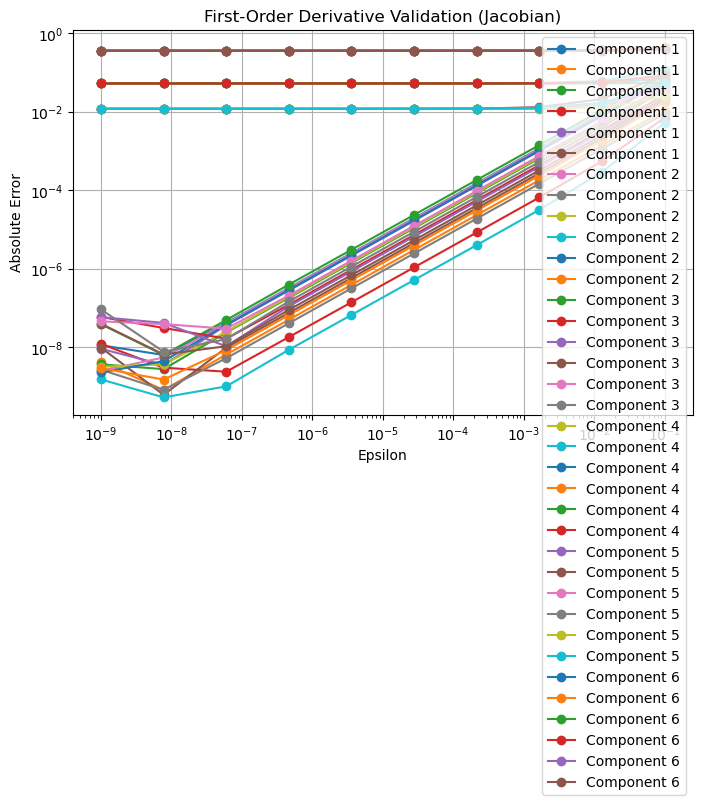

In [ ]:
def validate_jacobian(dt, x, f, J_f, epsilons=np.logspace(-9, -1, 10)):
    """
    Validate first-order derivatives by comparing finite difference with the Jacobian.
    """
    v = np.random.randn(len(x))  # Random direction
    v /= np.linalg.norm(v)  # Normalize

    errors = []
    for eps in epsilons:
        num_derivative = (f(eps, x + eps * v) - f(eps, x)) / eps
        analytic_derivative = J_f(eps, x) @ v
        errors.append(num_derivative - analytic_derivative)

    errors = np.array(errors)

    plt.figure(figsize=(8, 5))
    for i in range(errors.shape[1]):
        plt.loglog(epsilons, np.abs(errors[:, i]), marker='o', label=f'Component {i+1}')
    
    plt.xlabel("Epsilon")
    plt.ylabel("Absolute Error")
    plt.title("First-Order Derivative Validation (Jacobian)")
    plt.legend()
    plt.grid(True)
    plt.show()

dt = 0.01
x_test = np.random.multivariate_normal(mean=[0, 0, 0, 0, 0, 0], cov=np.eye(6)).reshape((6, 1))

validate_jacobian(dt, x_test, f, df_dx)